In [193]:
# Import everything we will need
import spectrapepper
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib.pyplot import figure, show, close
import matplotlib as mpl
from astropy.visualization import ImageNormalize, SquaredStretch
import scipy.signal as ss
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

In [194]:
# Define where the directory is located
datadir2 = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Live"
datadir = "C:/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope"
procdir = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Process/i"

# Use pathlib.Path to create a pathobject
pathobject = Path(datadir)
pathobject2 = Path(datadir2)

myfitsfiles = []
myfitsfiles2 = []

# Loop over all files in the directory and grab the fits files
for f in pathobject.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles.append(f)
        
for f in pathobject2.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles2.append(f)

# Print first 10 fitsfiles to check if we got everything correct        
for i in range(10):
    print(myfitsfiles[i])

C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000001.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000002.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000003.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000004.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000005.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000006.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000007.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000008.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000009.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000010.BIAS.FIT


In [195]:
# Create the image class

class image:
    def __init__(self, filepath, fits_imagetyp='', fits_exptime=0, fits_filter='', fits_date_obs=0, fits_naxis1=0, fits_naxis2=0, pixelsize=18):
        self.filepath = filepath
        self.filename = filepath.name
        self.imagetyp = fits_imagetyp
        self.exptime = fits_exptime
        self.filter = fits_filter
        self.date_obs = fits_date_obs
        self.naxis1 = fits_naxis1
        self.naxis2 = fits_naxis2
        self.pixelsize = pixelsize

myimages = []
myimages2 = []

# Loop over all of the filepaths in myfitsfiles, open each image, give it the image class and append it to the list of images
for filepath in myfitsfiles:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ')) 
    myimages.append(newimage)
    hdulist.close()

for filepath in myfitsfiles2:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ'))
    myimages2.append(newimage)
    hdulist.close()    

# Comment for self: Dark Frame, Bias Frame, Flat Field, Light Frame

438.0 11552.0 450.56004906354957


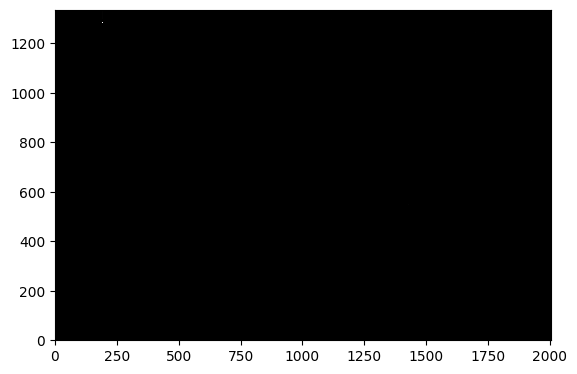

In [196]:
# Create the masterbias
# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Bias_list = []
count = 0
for im in myimages2:
    if 'bias frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Bias_list.append(dat)
        hdulist.close

# Then we median combine the images        
Bias_stack = np.stack(Bias_list)
masterbias = np.median(Bias_stack, axis=0)

del Bias_list

# These look pretty good, just weird it doesn't show up on the plot
print(masterbias.min(), masterbias.max(), masterbias.mean())

# Show the resulting masterbias
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterbias, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

-1.2333333333333334 58.64333333333333 -0.0007344978207258131


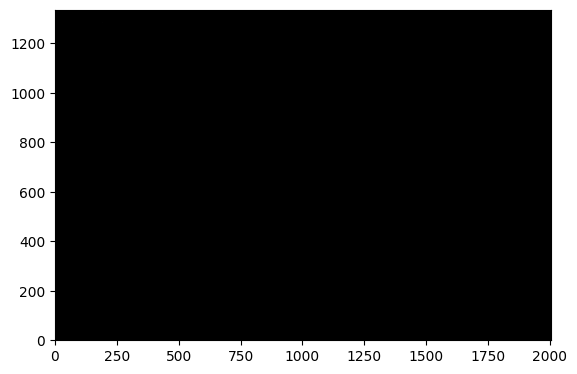

In [197]:
# Create the masterdark
# Loop over all the images in our list and check if they are Dark frames, if they are append them to the list
# We didn't have time to shoot our own darks, so we used older ones

Darks_list = []
count = 0
for im in myimages:
    if 'dark frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Darks_list.append((dat - masterbias)/im.exptime)
        hdulist.close

# Then we median combine the darks
Darks_stack = np.stack(Darks_list)
masterdark = np.median(Darks_stack, axis=0)

del Darks_list

# The min, max and mean look pretty good, just weird it doesn't show up on the plot
print(masterdark.min(), masterdark.max(), masterdark.mean())

# Show the resulting masterdark
fig = figure()
frame = fig.add_subplot(1,1,1)
norm = ImageNormalize(vmin=5, vmax=100, stretch=SquaredStretch())
frame.imshow(masterdark, interpolation='none', origin='lower', cmap='gray', norm=norm)
show(fig)
close(fig)


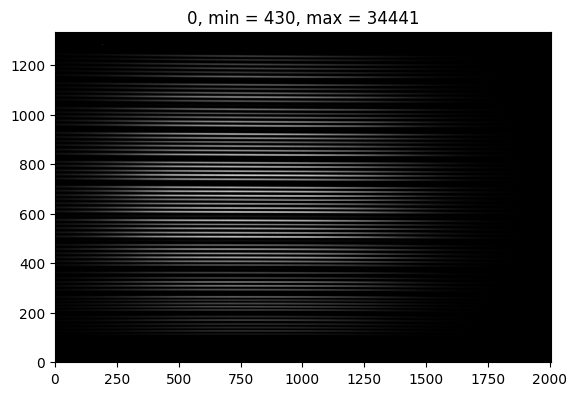

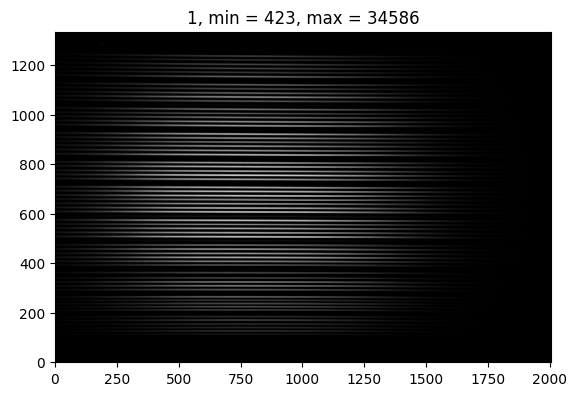

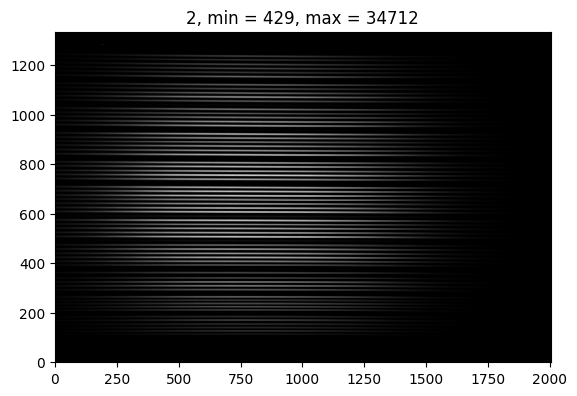

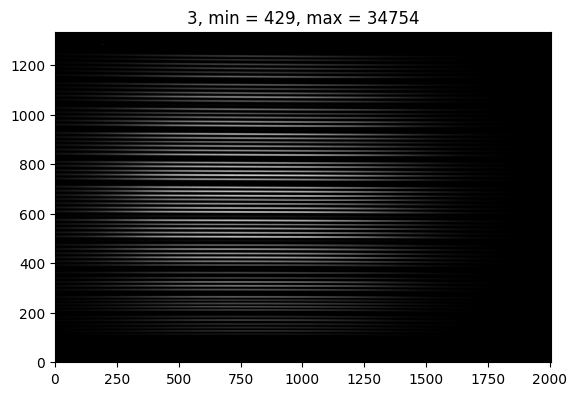

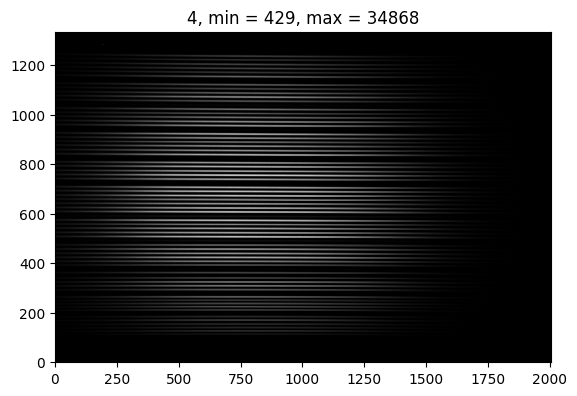

In [198]:
# Let's do the masterflat next

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Flats_list = []
count = 0
for im in myimages2:
    if 'flat field' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Flats_list.append(dat)
        hdulist.close

# Lets inspect the Flats
c = 0
for obj in Flats_list:
    fig = figure()
    frame = fig.add_subplot(1,1,1)
    norm = ImageNormalize(stretch=SquaredStretch())
    frame.imshow(obj, interpolation='none', origin='lower', cmap='gray', norm=norm)
    frame.set_title(f"{c}, min = {np.min(obj)}, max = {np.max(obj)}")
    show(fig)
    close(fig)
    c += 1

# We see that the first 5 show a proper flat
Flats_list_sorted = Flats_list[0:4]

del Flats_list

-0.2622589531680441 12.556106519742885 2.132789446730223


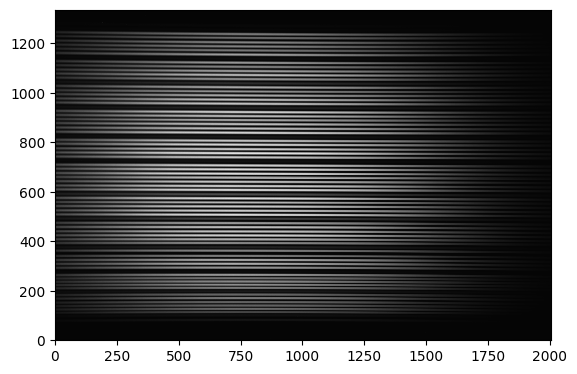

In [199]:
# Then we calibrate the flats with masterbias and median combine the images (We don't need to concern with the darks as the dark current can't really build up during flats
Flats_stack = np.stack(Flats_list_sorted-masterbias)

del Flats_list_sorted

Flats_median = np.median(Flats_stack)
Flats_stack_normalized = Flats_stack/Flats_median
masterflat_to_be_normalized = np.median(Flats_stack_normalized, axis=0)
masterflat = masterflat_to_be_normalized/np.median(masterflat_to_be_normalized)


print(masterflat.min(), masterflat.max(), masterflat.mean())

# Show the resulting masterflat
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.imshow(masterflat, interpolation='none', origin='lower', cmap='gray')
show(fig)
close(fig)

In [200]:
# Now that we have our master calibration files we can work on our lights, first we calibrate
lights = []
for im in myimages2:
    if 'light frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        data = hdulist[0].data.astype(float)
        data -= masterdark*im.exptime + masterbias
        # data /= masterflat
        lights.append(data)
        hdulist.close
        
# Let's inspect the lights
# c = 0
# for obj in lights:
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.imshow(obj, interpolation='none', origin='lower', cmap='gray')
#     frame.set_title(f"light {c} with min: {obj.min()}, max: {obj.max()}")
#     show(fig)
#     close(fig)
#     c += 1

In [201]:
def median_combine(lights_sorted):
    '''
    :param: lights_sorted: list of light frames
    :return: median of light frames 
    '''
    return np.median(np.stack(lights_sorted), axis=0)


# Based on the logsheet and printing all images we determine the following sorting of the targets
lights_sorted_galaxy = lights[32:34]+lights[36:42]
lights_sorted_vega = lights[43:48]
lights_sorted_moon = lights[-5:-1]
lights_calibration = lights[21:25]
lights_sorted_arcturus = lights[29:31]
lights_sorted_regulus = lights[26:27]

del lights

master_galaxy = median_combine(lights_sorted_galaxy)
master_vega = median_combine(lights_sorted_vega)
master_moon = median_combine(lights_sorted_moon)
master_calibration = median_combine(lights_calibration)
master_arcturus = median_combine(lights_sorted_arcturus)
master_regulus = median_combine(lights_sorted_regulus)

In [202]:
# Now that we have a program which calibrates the images we can start on figuring out where the spectral lines are. This is easiest done by using the flat frames first slice in a vertical line
vert_slice = masterflat[:,1000]

# Based on the plot we want to exclude values with less then 10000 counts
fibre_locations = np.where(vert_slice>3)[0]

# Now we would like to group all of the values in a single fibre into a single median value to reduce noise, although we do clearly see that the values on the outside are significantly less then the ones in the center.
fibre_locations_dict = {}
i = 1
n = "fibre_0"
c = 0

# Exclude outer 2, because poor signal to noise ratio 
# And add weighting, cause these tops be looking hella mid

for obj in fibre_locations:
    try:
        if obj+1 == fibre_locations[i]:
            try:
                fibre_locations_dict[n].append(obj)
            except:
                fibre_locations_dict[n] = []
                fibre_locations_dict[n].append(obj)
        else:
            fibre_locations_dict[n].append(obj)
            c+=1
            n = f'fibre_{c}'        
        i+=1
    
    except:
        fibre_locations_dict[n].append(obj)
# print(fibre_locations_dict)

# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(vert_slice)
# # frame.axis([600, 700, 8, 10])
# frame.set_title('Veritcal slice at x = 1000')
# frame.set_xlabel('Pixel from top to bottom')
# frame.set_ylabel('Intensity [counts]')
# frame.grid(alpha = 0.5)
# fig.savefig('Flatfield.png', dpi=300)
# show(fig) 
# close(fig)

In [203]:
# Now that we have the locations of the fibres we make an intensity plot of the median of all the collumns that a fibre consists of.
def find_maximum_slice(horizontal_slice_dict):
    '''
    :purpose: Finds the location of the slice which contains the maximum value
    :input: Dictionary medians of horizontal slices
    :return: The location of the slice which contains the maximum value
    '''
    Total_max = np.max(horizontal_slice_dict['fibre_0'])
    for i in horizontal_slice_dict:
        Max_of_row = np.max(horizontal_slice_dict[i])
        if Max_of_row>Total_max:
            Total_max = Max_of_row
            location = i
    return location

def average_fibre(fibre_locations_dict,master,flat_slice_dict={}):
    '''
    :purpose: Calculates the weighted average of each fibre
    :param: fibre_locations_dict, master
    :return: Dictionary of numbered fibres
    '''
    if len(flat_slice_dict)==0:
        flat_slice_dict = {}
        flat_slice_average_dict = {}
        for i in fibre_locations_dict:
            flat_slice = master[fibre_locations_dict[i],:]
            flat_slice_dict[i] = flat_slice
            flat_slice_average_dict[i] = np.average(flat_slice, axis=0, weights=flat_slice)
        return flat_slice_dict,flat_slice_average_dict
    else:
        horizontal_slice_dict_average = {}
        for i in fibre_locations_dict:
            horizontal_slice = master[fibre_locations_dict[i],:]
            horizontal_slice_dict_average[i] = np.average(horizontal_slice, axis=0, weights = flat_slice_dict[i])
        return horizontal_slice_dict_average
   
# Calculate the weighted average of each of the fibres     
flat_slice_dict, flat_slice_average_dict = average_fibre(fibre_locations_dict,masterflat)
horizontal_slice_galaxy_dict = average_fibre(fibre_locations_dict,master_galaxy,flat_slice_dict)   
horizontal_slice_vega_dict = average_fibre(fibre_locations_dict,master_vega,flat_slice_dict)
horizontal_slice_moon_dict = average_fibre(fibre_locations_dict,master_moon,flat_slice_dict)
horizontal_slice_calibration_dict = average_fibre(fibre_locations_dict,master_calibration,flat_slice_dict)
horizontal_slice_arcturus_dict = average_fibre(fibre_locations_dict,master_arcturus,flat_slice_dict)
horizontal_slice_regulus_dict = average_fibre(fibre_locations_dict,master_regulus,flat_slice_dict)

# We want to save the horizontal_slice_dict and use it in further stuff
location_of_maximum_galaxy_dict = find_maximum_slice(horizontal_slice_galaxy_dict)
location_of_maximum_vega = find_maximum_slice(horizontal_slice_vega_dict)
location_of_maximum_moon = find_maximum_slice(horizontal_slice_moon_dict)
location_of_maximum_calibration = find_maximum_slice(horizontal_slice_calibration_dict)
location_of_maximum_arcturus = find_maximum_slice(horizontal_slice_arcturus_dict)
location_of_maximum_regulus = find_maximum_slice(horizontal_slice_regulus_dict)


# horizontal_slice_dict = {}
# horizontal_slice_moon_dict = {}
# horizontal_slice_dict_average = {}
# vega_slice_dict_average = {}
# calibration_horizontal_dict = {}
# flat_horizontal_slice_dict = {}
# flat_horizontal_slice_dict_average = {}

# # Loop over all the fibres
# for i in fibre_locations_dict:
#     # Do the slicing
#     horizontal_slice = masterlight[fibre_locations_dict[i],:]
#     flat_horizontal_slice = masterflat[fibre_locations_dict[i], :]/np.median([masterflat[fibre_locations_dict[i], :]])
#     calibration_horizontal_slice = mastercalibration[fibre_locations_dict[i], :]
#     vega_slice = mastervega[fibre_locations_dict[i], :]
#     # Take the median
#     horizontal_slices_median = np.median(horizontal_slice, axis=0)
#     flat_horizontal_slice_median = np.median(flat_horizontal_slice, axis=0)
#     calibration_horizontal_slice_median = np.median(calibration_horizontal_slice, axis=0)
#     # Try adding weighting to the different pixels in an attempt to reduce the noise
#     horizontal_slices_mean = np.average(horizontal_slice, axis=0, weights = flat_horizontal_slice)
#     flat_horizontal_slice_mean = np.average(flat_horizontal_slice, axis=0, weights = flat_horizontal_slice)
#     vega_slice_mean = np.average(vega_slice, axis=0, weights = flat_horizontal_slice)
#     # Add this median line to the dictionary
#     horizontal_slice_dict[i] = horizontal_slices_median
#     horizontal_slice_dict_average[i] = horizontal_slices_mean
#     calibration_horizontal_dict[i] = calibration_horizontal_slice_median
#     flat_horizontal_slice_dict[i] = flat_horizontal_slice_median
#     flat_horizontal_slice_dict_average[i] = flat_horizontal_slice_mean
#     vega_slice_dict_average[i] = vega_slice_mean
    
# We want to calculate the average of all the lights 

# # Plot fibre with max intensity
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# # frame.plot(horizontal_slice_dict[location_of_maximum]/flat_horizontal_slice_dict[location_of_maximum], label = 'median')
# # frame.plot(vega_slice_dict_average[location_of_maximum]/flat_horizontal_slice_dict_average[location_of_maximum], label = 'weighted average')
# frame.plot(horizontal_slice_calibration_dict[location_of_maximum_calibration])
# # frame.plot(horizontal_slice_arcturus_dict[location_of_maximum_calibration])
# # frame.plot(horizontal_slice_regulus_dict[location_of_maximum_calibration])
# frame.set_title(location_of_maximum_calibration)
# frame.grid()
# # fig.savefig('Median vs weighted average')
# show(fig)
# close(fig)

# for obj in fibre_locations_dict.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(horizontal_slice_dict[obj])
#     frame.set_title(obj)
#     frame.grid()
#     show(fig)
#     close(fig)

# horizontal_slice_list_sorted = horizontal_slice_list[27:31:1]
# median_slices = np.median(horizontal_slice_list_sorted, axis=0)

# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_horizontal_slice_dict_average[location_of_maximum])
# frame.set_title("median of main fibres")
# frame.grid()
# show(fig)
# close(fig)

In [204]:
# Shift calculation based on the biggest spike in the calibration data!
def calculate_shifts(calibration_dict):
    ''''
    :purpose: Calculates the relative shift between the fibres using the calibration data
    :param calibration_dict: Dictionary of numbered fibres of calibration data
    :return shifts: Dictionary of shifts as to allign all fibres 
    '''
    Maximums = {}
    Maximums_list = []
    shifts = {}

    for i in calibration_dict.keys():
        Maximum = np.where(calibration_dict[i]==np.max(calibration_dict[i]))[0][0]
        Maximums[i] = Maximum
        Maximums_list.append(Maximum)
    centre = np.median(Maximums_list)
    
    for i in calibration_dict.keys():
        shifts[i] = centre - Maximums[i]
    return(shifts)

shifts = calculate_shifts(horizontal_slice_calibration_dict)

In [205]:
def align_spectra(average_dict, shifts):
    '''
    :purpose: Aligns and crops all the fibres such that there is no longer a relative horizontal shift between the fibres
    :param average_dict: Dictionary of light frames
    :param shifts: Dictionary of relative shifts
    :return cropped: Dictionary of aligned fibres
    '''
    # First align the fibres
    aligned_average_dict = {}
    for i in average_dict.keys():
        if shifts[i] > 0:
            shift = int(shifts[i])
            aligned_average_dict[i] = average_dict[i][shift::]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],0,np.zeros(shift))
        if shifts[i] < 0:
            shift = int(abs(shifts[i]))
            aligned_average_dict[i] = average_dict[i][:-shift:]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],-1,np.zeros(shift))
        else:
            aligned_average_dict[i] = average_dict[i]
  
    # After alligning we can crop
    maximum_shift = 0
    minimum_shift = 0
    cropped = {}
    for i in shifts:
        if shifts[i] > maximum_shift:
            maximum_shift = shifts[i]
        elif shifts[i] < minimum_shift:
            minimum_shift = shifts[i]

    minimum_shift = int(abs(minimum_shift))
    maximum_shift = int(abs(maximum_shift))

    for i in aligned_average_dict.keys():
        cropped[i] = aligned_average_dict[i][maximum_shift:-minimum_shift:]
        
    return cropped
# def crop_spectra(aligned_average_dict, shifts):
#     maximum_shift = 0
#     minimum_shift = 0
#     cropped = {}
#     for i in shifts:
#         if shifts[i] > maximum_shift:
#             maximum_shift = shifts[i]
#         elif shifts[i] < minimum_shift:
#             minimum_shift = shifts[i] 
#     
#     minimum_shift = int(abs(minimum_shift))
#     maximum_shift = int(abs(maximum_shift))
#     
#     for i in aligned_average_dict.keys():
#         cropped[i] = aligned_average_dict[i][maximum_shift:-minimum_shift:]
#     return cropped, minimum_shift, maximum_shift
#     
def background_subtraction(aligned_average_dict):
    '''
    :purpose: subtract the background to see fainter emmision and absorption lines
    :param aligned_average_dict: Dictionary of light frames
    :return background_subtracted: Dictionary of background subtracted fibres
    '''
    aligned_average_list = []
    for i in aligned_average_dict.keys():
        aligned_average_list.append(aligned_average_dict[i])
    aligned_stack = np.stack(aligned_average_list)
    background = np.median(aligned_stack, axis=0)
    
    background_subtracted = {}
    for i in aligned_average_dict.keys():
        background_subtracted[i] = aligned_average_dict[i] / background
    return background_subtracted

# def background_subtraction(aligned_average_dict,background):
#     background_subtracted = {}
#     for i in aligned_average_dict.keys():
#         background_subtracted[i] = aligned_average_dict[i] / background
#     return background_subtracted

# fix the relative shift between the fibres
cropped_flat = align_spectra(flat_slice_average_dict, shifts)
cropped_galaxy = align_spectra(horizontal_slice_galaxy_dict, shifts)
cropped_vega = align_spectra(horizontal_slice_vega_dict, shifts)
cropped_moon = align_spectra(horizontal_slice_moon_dict, shifts)
cropped_calibration = align_spectra(horizontal_slice_calibration_dict, shifts)
cropped_arcturus = align_spectra(horizontal_slice_arcturus_dict, shifts)
cropped_regulus = align_spectra(horizontal_slice_regulus_dict, shifts)

# Background subtract the galaxy data
galaxy_background_subtracted = background_subtraction(cropped_galaxy)

# for fibre in galaxy_background_subtracted.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(cropped_flat[fibre])
#     # frame.plot(wavelength_calibrated, aligned_average_dict[fibre]/aligned_average_dict[fibre].max())
#     frame.set_title(f"Background subtracted {fibre}")
#     frame.grid() 
#     show(fig)
#     close(fig)

In [206]:

# import specreduce
# from specreduce.calibration_data import load_onedstds
# 
# 
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_horizontal_slice_dict[location_of_maximum])
# frame.set_title("flat horizontal slice")
# frame.grid()
# show(fig)
# close(fig)
# 
# flat_calibrated = horizontal_slice_dict[location_of_maximum]/(flat_horizontal_slice_dict[location_of_maximum]/np.median(flat_horizontal_slice_dict[location_of_maximum]))
# 
# # Baseline is basically noise reduction for the spectroscope (Not sure if worth)
# baseline = spectrapepper.alsbaseline(flat_calibrated, lam=10)
# smoothest_baseline = flat_calibrated - spectrapepper.alsbaseline(flat_calibrated, lam=100000)
# baseline_subtracted = flat_calibrated - baseline
# continuum_removed = flat_calibrated / baseline_subtracted
# 
# # Same thing but now do it for weighted average
# flat_calibrated_average = horizontal_slice_dict_average[location_of_maximum]/(flat_horizontal_slice_dict_average[location_of_maximum]/np.median(flat_horizontal_slice_dict_average[location_of_maximum]))
# baseline_average = spectrapepper.alsbaseline(flat_calibrated_average, lam=10)
# smoothest_baseline_average = flat_calibrated_average - spectrapepper.alsbaseline(flat_calibrated_average, lam=100000)
# baseline_subtracted_average = flat_calibrated_average - baseline_average
# continuum_removed_average = flat_calibrated_average / baseline_subtracted_average
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline)
# frame.set_title("alsbaseline")
# frame.grid()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_calibrated)
# frame.set_title("alsbaseline")
# frame.grid()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline_subtracted)
# frame.set_title("alsbaseline")
# frame.grid()
# show(fig)
# close(fig)
# 
# # flat_calibrated = horizontal_slice_dict['fibre_27']/(horizontal_slice_moon_dict['fibre_27']/np.median(horizontal_slice_moon_dict['fibre_27']))
# 
# flat_calibrated = flat_calibrated[-1::-1]   # Flip
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_calibrated)
# frame.set_title(f"{location_of_maximum} flat calibrated")
# frame.grid()
# show(fig)
# close(fig)


In [207]:
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(flat_calibrated[::-1], label = 'median')
# frame.plot(flat_calibrated_average, label = 'average')
# frame.set_title(f"{location_of_maximum} flat calibrated")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline_subtracted, label = 'median')
# frame.plot(baseline_subtracted_average, label = 'average')
# frame.set_title(f"{location_of_maximum} baseline_subtracted")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(baseline, label = 'median')
# frame.plot(baseline_average, label = 'average')
# frame.set_title(f"{location_of_maximum} baseline")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)

In [208]:
# from matplotlib.pyplot import subplots
# 
# # baseline_subtracted, smoothest_baseline = -baseline_subtracted, -smoothest_baseline
# 
# fig, ax = subplots()
# ax.plot(flat_calibrated[::-1]/flat_calibrated.max(), label="raw")
# ax.plot(smoothest_baseline/smoothest_baseline.max(), label="smooth")
# ax.plot(baseline_subtracted/baseline_subtracted.max(), label="baseline")
# fig.legend()
# show()
# close(fig)
# 
# 
# dat2 = baseline_subtracted
# data_var = baseline_subtracted - smoothest_baseline
# 
# fig, ax = subplots()
# ax.plot(data_var)
# show()
# close(fig)
# 
# deriv = []
# der2 = []
# for i in range(data_var.size-1):
#     d = data_var[i+1]-data_var[i]
#     d2 = dat2[i+1]-dat2[i]
#     deriv.append(d)
#     der2.append(d2)
# deriv = np.array(deriv)/np.max(deriv)
# der2 = np.array(der2)/np.max(der2)
# fig, ax = subplots(1, 1)
# ax.plot(((deriv)), label="baseline")
# ax.plot(der2, label="baseline - smooth")
# ax.grid()
# ax.legend(loc='best')
# show()
# close(fig)
# 
# data_var = deriv
# deriv = []
# 
# for i in range(data_var.size-1):
#     d = data_var[i+1]-data_var[i]
#     deriv.append(d)
# deriv = np.array(deriv)/np.max(deriv)
# fig, ax = subplots()
# fin = 10**((deriv))
# ax.plot(fin/fin.max())
# fin_base = baseline_subtracted - smoothest_baseline 
# ax.plot(fin_base/fin_base.max())
# ax.grid()
# fig.set_tight_layout(True)
# show()
# close(fig)
# 
# 
# fig, ax = subplots()
# ax.plot(fin/fin.max(), label="peaks", alpha=0.5)
# ax.plot(baseline_subtracted/baseline_subtracted.max(), label="baseline")
# ax.grid()
# show()
# close(fig)
# # Timo code

In [209]:
# from matplotlib.pyplot import subplots
# 
# # baseline_subtracted, smoothest_baseline = -baseline_subtracted, -smoothest_baseline
# 
# fig, ax = subplots()
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw")
# ax.plot(smoothest_baseline_average/smoothest_baseline_average.max(), label="smooth")
# ax.plot(baseline_subtracted_average/baseline_subtracted_average.max(), label="baseline")
# fig.legend()
# show()
# close(fig)
# 
# 
# dat2_average = baseline_subtracted_average
# data_var_average = baseline_subtracted_average - smoothest_baseline_average
# 
# fig, ax = subplots()
# ax.plot(data_var_average)
# show()
# close(fig)
# 
# deriv_average = []
# der2_average = []
# for i in range(data_var_average.size-1):
#     d_average = data_var_average[i+1]-data_var_average[i]
#     d2_average = dat2_average[i+1]-dat2_average[i]
#     deriv_average.append(d_average)
#     der2_average.append(d2_average)
# deriv_average = np.array(deriv_average)/np.max(deriv_average)
# der2_average = np.array(der2_average)/np.max(der2_average)
# fig, ax = subplots(1, 1)
# ax.plot(((deriv_average)), label="baseline")
# ax.plot(der2_average, label="baseline - smooth")
# ax.grid()
# ax.legend(loc='best')
# show()
# close(fig)
# 
# data_var_average = deriv_average
# deriv_average = []
# 
# for i in range(data_var_average.size-1):
#     d_average = data_var_average[i+1]-data_var_average[i]
#     deriv_average.append(d_average)
# deriv_average = np.array(deriv_average)/np.max(deriv_average)
# 
# fig, ax = subplots()
# fin_average = 10**((deriv_average))
# ax.plot(fin_average/fin_average.max())
# fin_base_average = baseline_subtracted_average - smoothest_baseline_average
# ax.plot(fin_base_average/fin_base_average.max())
# ax.grid()
# fig.set_tight_layout(True)
# show()
# close(fig)
# 
# 
# fig, ax = subplots()
# ax.plot(fin_average/fin_average.max(), label="peaks", alpha=0.5)
# ax.plot(baseline_subtracted_average/baseline_subtracted_average.max(), label="baseline")
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw")
# ax.grid()
# show()
# close(fig)
# # Timo code 2

In [210]:
# # %matplotlib
# fig, ax = subplots()
# ax.plot(fin/fin.max(), label="peaks", alpha=0.5)
# ax.plot(fin_average/fin_average.max(), label="average peaks", alpha = 0.5)
# ax.plot(flat_calibrated_average/flat_calibrated_average.max(), label="raw average", alpha = 0.5)
# ax.plot(flat_calibrated[::-1]/flat_calibrated.max(), label="raw median", alpha = 0.5)
# ax.legend()
# ax.grid()
# show(block=True)
# close(fig)

In [211]:
# from specreduce.calibration_data import load_pypeit_calibration_lines, load_onedstds, load_MAST_calspec
# 
# 
# # print(specreduce.calibration_data.PYPEIT_CALIBRATION_LINELISTS)
# 
# ZnI = load_pypeit_calibration_lines('ZnI')
# HgI = load_pypeit_calibration_lines('HgI')
# CdI = load_pypeit_calibration_lines('CdI')
# 
# wavelengthZnI = []
# amplitudeZnI = []
# for i in range(len(ZnI)):
#     row=ZnI[i]
#     wave = row['wave']
#     wavelengthZnI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeZnI.append(amplitude)
# 
# wavelengthHgI = []
# amplitudeHgI = []
# for i in range(len(HgI)):
#     row=HgI[i]
#     wave = row['wave']
#     wavelengthHgI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeHgI.append(amplitude)
# 
# wavelengthCdI = []
# amplitudeCdI = []
# for i in range(len(CdI)):
#     row=CdI[i]
#     wave = row['wave']
#     wavelengthCdI.append(wave.value)
#     amplitude = row['amplitude']
#     amplitudeCdI.append(amplitude)
# 
# # np.array(amplitudeZnI)
# # np.array(amplitudeHgI)
# # np.array(amplitudeCdI)
# # np.array(amplitudeZnI)
# # np.array(amplitudeHgI)
# # np.array(amplitudeCdI)
# # 
# # combine_amplitude = amplitudeZnI+amplitudeHgI+amplitudeCdI
# # combine_wavelength = wavelengthZnI+wavelengthHgI+wavelengthCdI
# 
# 
# 
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelengthZnI, amplitudeZnI)
# frame.plot(wavelengthHgI, amplitudeHgI)
# frame.plot(wavelengthCdI, amplitudeCdI)
# frame.set_title("Spectral lines")
# frame.set_xlabel(f"Wavelength")
# frame.set_ylabel(f"Flux")
# frame.grid()
# show(fig)
# close(fig)
# 
# 
# # WARNING: Downloading of https://raw.githubusercontent.com/astropy/specreduce-data/main/specreduce_data/reference_data/onedstds\gemini\BD+28 4211 failed: URL can't contain control characters. '/astropy/specreduce-data/main/specreduce_data/reference_data/onedstds\\gemini\\BD+28 4211' (found at least ' ') [specreduce.calibration_data]
# # WARNING: Can't load BD+28 4211 from gemini. [specreduce.calibration_data]
# Specreduce

In [212]:
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# for fibre in calibration_horizontal_dict.keys():
#     frame.plot(calibration_horizontal_dict[fibre], label = fibre)
# frame.set_title(f"Calibration data")
# frame.grid()
# show(fig)
# close(fig)

[ 501  565 1040 1057 1308 1596 1612 1842 1907 1909 1943]


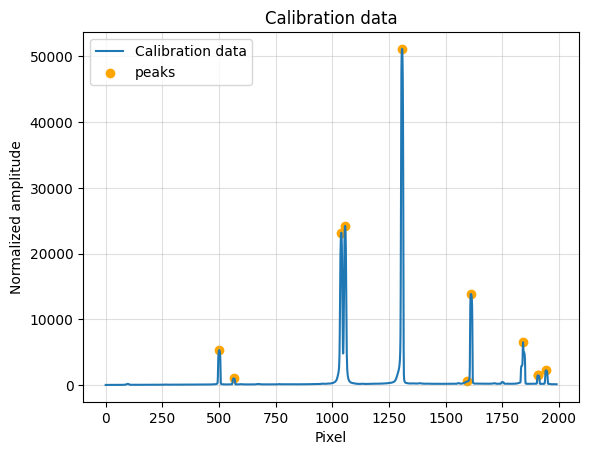

In [213]:
# get the actual peaks
peaks, _ = find_peaks(cropped_calibration[location_of_maximum_calibration], height=500)

print(peaks)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_calibration[location_of_maximum_calibration], label = 'Calibration data')
frame.scatter(peaks, cropped_calibration[location_of_maximum_calibration][peaks],color='orange', label = 'peaks', marker = 'o')
frame.set_title(f"Calibration data")
frame.set_ylabel('Normalized amplitude')
frame.set_xlabel('Pixel')
frame.grid(alpha = 0.4)
frame.legend(loc = 'upper left')
fig.savefig('Calibration data')
show(fig)
close(fig)


# # Create visual for presentation
# fibres = ['fibre_5', 'fibre_15', 'fibre_25', 'fibre_35', 'fibre_45', 'fibre_55']
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# for fibre in fibres:
#     frame.plot(calibration_horizontal_dict[fibre]/np.max(calibration_horizontal_dict[fibre]), label = fibre)
# frame.axis([450, 550, 0, 0.15])
# frame.set_title(f"Calibration data shift")
# frame.set_ylabel('Normalized amplitude')
# frame.set_xlabel('Pixel')
# frame.grid(alpha = 0.4)
# frame.legend()
# fig.savefig('Calibration data shift')
# show(fig)
# close(fig)

 
-1.217 x + 7052


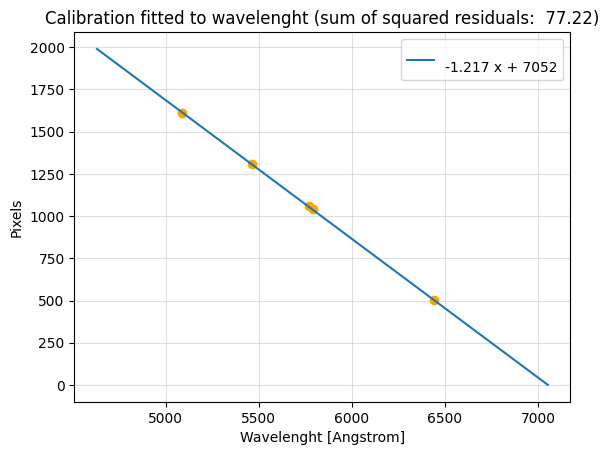

In [214]:
pixels_xaxis = cropped_calibration[location_of_maximum_calibration].shape[0]

# We don't want to use all of the peaks because some cannot be identified
Our_peak_location = peaks[np.array([0,2,3,4,6])]
Calibration_peak_locations = np.array([6438, 5791, 5770, 5461, 5086])

Lenght_our_x_axis = np.arange(0,pixels_xaxis, 1)

def wavelengthfit(a1,c1, degree):
    ''''
    :purpose: Function to calculate the wavelength calibration polynomial
    :param: a1 and c1 are arrays where the first is the pixel values found and c1 are the wavelength values
    :return: wavelength calibration polynomial
    '''
    y = np.polyfit(a1,c1,degree, full=True)
    return(y)

Function = (wavelengthfit(Our_peak_location,Calibration_peak_locations, 1))
y = np.poly1d(Function[0])

print(y)

wavelength_calibrated = np.polyval(y, Lenght_our_x_axis)
# cropped_wavelength = wavelength_calibrated[maximum_shift:-minimum_shift:]

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Lenght_our_x_axis, label = y)
frame.scatter(Calibration_peak_locations, Our_peak_location, color='orange')
# frame.plot(Y, range(Y.size))
frame.set_title(f"Calibration fitted to wavelenght (sum of squared residuals: {Function[1][0]: .4})")
frame.grid(alpha = 0.4)
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Pixels')
fig.savefig('Calibration fitted to wavelenght.png', dpi=300)
show(fig)
close(fig)

In [215]:
def peaks_to_wavelength(Array_with_y):
    '''
    :purpose: Function that converts an array of pixels to an array of wavelengths
    :param Array_with_y: Array of x,y coördinate peaks
    :return: 
    '''
    peaks_pixel = []
    for x,_ in Array_with_y:
        peaks_pixel.append(int(x))
    return np.sort(peaks_pixel)[::-1], np.sort(np.polyval(y,peaks_pixel))


# We should get this from Timo when it is added to notebook
Arcturus_peaks_with_y = np.array([(1793, 1.0), (399, 0.6428682518322371), (133, 0.33515624708759745), (958, 0.1), (1546,0.3)])
Vega_peaks_with_y = np.array([(198, 1.0), (1597, 0.0010763035604415474), (1863, 0.0007290668308719731)])
Regulus_peaks_with_y = np.array([(1797, 1.0), (398, 0.09840773414254268), (132, 0.015318963453609722)])
Moon_peaks_with_y = np.array([(396, 1.0), (954, 0.6383212534573891), (128, 0.5756135064147742), (1546, 0.2567646603528924), (1797, 0.012043490921988769)])

Arcturus_peaks_pixel, Arcturus_peaks = peaks_to_wavelength(Arcturus_peaks_with_y)
Vega_peaks_pixel = np.sort([131,  399, 1798])[::-1]
Vega_peaks = np.sort(np.polyval(y,Vega_peaks_pixel))
Regulus_peaks_pixel = np.sort([131,  399, 1797])[::-1]
Regulus_peaks = np.sort(np.polyval(y,Regulus_peaks_pixel))
Moon_peaks_pixel, Moon_peaks = peaks_to_wavelength(Moon_peaks_with_y)

print(f"Arcturus: ", Arcturus_peaks, Arcturus_peaks_pixel)
print(f"Vega: ", Vega_peaks, Vega_peaks_pixel)
print(f"Regulus: ", Regulus_peaks, Regulus_peaks_pixel)
print(f"Moon: ", Moon_peaks, Moon_peaks_pixel)

Arcturus:  [4870.3209949  5170.87671619 5886.36968834 6566.5747418  6890.25013396] [1793 1546  958  399  133]
Vega:  [4864.23687098 6566.5747418  6892.68378353] [1798  399  131]
Regulus:  [4865.45369577 6566.5747418  6892.68378353] [1797  399  131]
Moon:  [4865.45369577 5170.87671619 5891.23698747 6570.22521615 6896.33425787] [1797 1546  954  396  128]


In [216]:
# Identify the peaks
n_vega = ['Hβ - 4870','Hα - 6567','O2 - 6892']
n_Arcturus = ['Hβ - 4870','Mg I - 5178', 'Na I - 5894', 'Hα - 6567','O2 - 6892']
n_Regulus = ['Hβ - 4870', 'Hα - 6573', 'O2 - 6897']
n_Moon = ['Hβ - 4864', 'Mg I - 5169', 'Na I - 5890', 'O2 - 6896', 'Hα - 6569']

In [217]:
# n_vega = ['Hβ - 4870','Hα - 6567','O2 - 6892']
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelength_calibrated, cropped_vega[location_of_maximum_vega], label = 'Vega spectrum')
# frame.plot(Vega_peaks,cropped_vega[location_of_maximum_vega][Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
# for i, txt in enumerate(n_vega):
#     frame.annotate(txt, (Vega_peaks[i], vega_cropped[location_of_maximum_vega][Vega_peaks_pixel][i]), (Vega_peaks[i]-250, vega_cropped[location_of_maximum_vega][Vega_peaks_pixel][i]-1100))
# frame.set_title(f"Vega spectrum")
# frame.set_ylabel('Intensity [counts]')
# frame.set_xlabel('wavelength [Ångström]')
# frame.legend()
# frame.grid(alpha = 0.4)
# # fig.savefig('Vega.png', dpi=300)
# show(fig)
# close(fig)

In [218]:
# # n_arcturus = ['5894', '5274', '6899', '6574', '5787', '5178', '6507', '5334', '5710', '5592', '5409', '6168']
# # n_arcturus = [[5893.73847649 6574.19367676 5272.92961758 5785.40124425 6897.98810121 5175.54783579 5712.36490791 5593.07222521 6508.46097405 5335.01050347 5410.48138436 5481.08317616]]

# Arcturus = np.loadtxt('Arcturus.txt')
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelength_calibrated, Arcturus, label = 'Arcturus spectrum')
# frame.plot(Arcturus_peaks,Arcturus[Arcturus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
# for i, txt in enumerate(n_Arcturus):
#     frame.annotate(txt, (Arcturus_peaks[i], Arcturus[Arcturus_peaks_pixel][i]), (Arcturus_peaks[i]-150, Arcturus[Arcturus_peaks_pixel][i]-5000))
# frame.set_title(f"Arcturus spectrum")
# frame.set_ylabel('Intensity [counts]')
# frame.set_xlabel('wavelength [Ångström]')
# frame.legend(loc = 'lower center')
# frame.grid(alpha = 0.4)
# # fig.savefig('Arcturus.png', dpi=300)
# show(fig)
# close(fig)

In [219]:
# n_Regulus = ['Hβ - 4870', 'Hα - 6573', 'O2 - 6897']
# Regulus = np.loadtxt('Regulus.txt')
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelength_calibrated, Regulus, label = 'Regulus spectrum')
# frame.plot(Regulus_peaks,Regulus[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
# for i, txt in enumerate(n_Regulus):
#     frame.annotate(txt, (Regulus_peaks[i], Regulus[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Regulus[Regulus_peaks_pixel][i]-250))
# frame.set_title(f"Regulus spectrum")
# frame.set_ylabel('Intensity [counts]')
# frame.set_xlabel('wavelength [Ångström]')
# frame.legend()
# frame.grid(alpha = 0.4)
# # fig.savefig('Regulus.png', dpi=300)
# show(fig)
# close(fig)

In [220]:
# # n_Moon = ['Hα - 6577', 'Na I - 5898', 'O2 - 6904', 'Fe I - 5178', 'Fe I - 5278']
# 
# n_Moon = ['Hβ - 4864', 'Mg I - 5169', 'Na I - 5890', 'O2 - 6896', 'Hα - 6569']
# # n_Moon = ['Hβ - 4864', 'Fe II - 5169', 'Fe I - 5269', 'Fe I - 5587', 'Fe I - 5704', 'Na I D doublet - 5890', 'Ca I - 6163', 'Hα - 6569', 'O2 - 6896']
# Moon = np.loadtxt('Moon.txt')
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelength_calibrated, Moon, label = 'Moon spectrum')
# frame.plot(Moon_peaks,Moon[Moon_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
# for i, txt in enumerate(n_Moon):
#     frame.annotate(txt, (Moon_peaks[i], Moon[Moon_peaks_pixel][i]), (Moon_peaks[i]-150, Moon[Moon_peaks_pixel][i]-3000))
# frame.set_title(f"Moon spectrum")
# frame.set_ylabel('Intensity [counts]')
# frame.set_xlabel('wavelength [Ångström]')
# frame.legend()
# frame.grid(alpha = 0.4)
# # fig.savefig('Moon.png', dpi=300)
# show(fig)
# close(fig)

In [221]:
# # Use the peak finder on certain spectra
# def continuum_removal(points):
#     x, y = points.T
#     augmented = np.concatenate([points, [(x[0], np.min(y)-1), (x[-1], np.min(y)-1)]], axis=0)
#     hull = ConvexHull(augmented)
#     continuum_points = points[np.sort([v for v in hull.vertices if v < len(points)])]
#     continuum_function = interp1d(*continuum_points.T)
#     yprime = y / continuum_function(x)
# 
#     return yprime
# 
# fibre = location_of_maximum
# 
# points = np.c_[wavelength_calibrated, cropped[fibre]]
# hull_subtracted = continuum_removal(points)
# 
# 
# # processed_signal = (background_subtracted[fibre])
# 
# 
# emmision, _ = find_peaks(hull_subtracted[::-1], height=1.093)
# absorption, _ = find_peaks(hull_subtracted[::-1]*-1, height=-0.9)
# 
# emmision_calibrated = np.polyval(y, emmision)
# absorption_calibrated = np.polyval(y, absorption)
# print(f"We find emmision lines: {emmision_calibrated[::-1]}")
# print(f"We find absorption lines:", absorption_calibrated[::-1])
# 
# # plt.plot(wavelength_calibrated, ss.wiener(background_subtracted[fibre], 80), label = "wiener")
# plt.plot(wavelength_calibrated, hull_subtracted[::-1])
# # plt.plot(wavelength_calibrated, aligned_average_dict[fibre][::-1])
# # plt.plot(wavelength_calibrated[::-1], convexhull)
# # plt.plot(wavelength_calibrated, spectrapepper.alsbaseline(aligned_average_dict[location_of_maximum], lam=1, remove=True))
# plt.plot(emmision_calibrated, hull_subtracted[::-1][emmision], "x")
# plt.plot(absorption_calibrated, hull_subtracted[::-1][absorption], "x")
# plt.grid()
# plt.show()


In [222]:
# Let's look for some lines
# 
# for fibre in background_subtracted.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(wavelength_calibrated, cropped[fibre])
#     frame.set_title(f"background_subtracted {fibre}")
#     frame.grid()
#     show(fig)
#     close(fig)

In [223]:
# continuum_subtracted = spectrapepper.alsbaseline(horizontal_slice_dict_average[location_of_maximum], lam=10, remove=True)
# # Do the same for the moon to look what is sky
# # continuum_subtracted_moon = spectrapepper.alsbaseline(horizontal_slice_dict_average[location_of_maximum], lam=10, remove=True)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# # frame.plot(horizontal_slice_dict_average[location_of_maximum], label = 'average')
# frame.plot(wavelength_calibrated, continuum_subtracted[::-1]/continuum_subtracted.max(), label = 'baseline_subtracted')
# # frame.plot(wavelength_calibrated, continuum_subtracted_moon[::-1]/continuum_subtracted_moon.max(), label = 'moon')
# 
# frame.set_title(f"{location_of_maximum} baseline")
# frame.grid()
# frame.legend()
# show(fig)
# close(fig)

In [224]:
# hdulist = fits.open('miles spectra/arcturus_miles.fits')
# hdr = hdulist[0].header
# dat = hdulist[0].data
# vega_miles = dat[0,:]
# print(vega_miles)

# getting some basic information on the miles spectrum

# hdulist = fits.open('miles_spec_fits_s0592.fits')
# 
# hdr = hdulist[0].header
# dat = hdulist[0].data
# vega_miles = dat[0,:]

# fig=figure()
# frame=fig.add_subplot(1,1,1)
# frame.plot(vega_calibration_wavelength, vega_calibration_values,color="navy", label="Vega spectrum")
# frame.set_title("Vega-like star spectrum from MILES")
# frame.grid(alpha=0.2)
# show()
# close(fig)
# print(vega_cropped)
# 
# fig=figure()
# frame=fig.add_subplot(1,1,1)
# frame.plot(wavelength_calibrated, np.loadtxt('calibration.txt'),color="navy", label="Vega spectrum")
# frame.set_title("Our Vega")
# frame.grid(alpha=0.2)
# show()
# close(fig)

In [225]:
vega_calibration = np.loadtxt('miles_spec_txt_s0592.txt')

wavelength = []
values = []

size = int(vega_calibration.size/2)

for i in range(size):
    wavelength.append(vega_calibration[i][0])
    values.append(vega_calibration[i][1])

# convert both to np arrays
vega_calibration_wavelength = np.array(wavelength)
vega_calibration_values = np.array(values)

# First we get the max and min values of our actual data
minimum_wavelength = wavelength_calibrated[-1]
maximum_wavelength = wavelength_calibrated[0]

# We crop the calibration data to our range
mask1 = vega_calibration_wavelength > minimum_wavelength
vega_calibration_wavelength = vega_calibration_wavelength[mask1]
vega_calibration_values = vega_calibration_values[mask1]

mask2 = vega_calibration_wavelength < maximum_wavelength
vega_calibration_wavelength = vega_calibration_wavelength[mask2]
vega_calibration_values = vega_calibration_values[mask2]

# Then we interpolate the calibration data so it matches ours
# la = len(aligned_average_dict[location_of_maximum])

interpolated_vega_calibration_values = np.interp(wavelength_calibrated, vega_calibration_wavelength, vega_calibration_values)

In [226]:
Vega_flat_calibrated = cropped_vega[location_of_maximum_vega]/(cropped_flat[location_of_maximum_vega]/np.median(cropped_flat[location_of_maximum_vega]))
Regulus_flat_calibrated = cropped_regulus[location_of_maximum_regulus]/(cropped_flat[location_of_maximum_regulus]/np.median(cropped_flat[location_of_maximum_regulus]))
Arcturus_flat_calibrated = cropped_arcturus[location_of_maximum_arcturus]/(cropped_flat[location_of_maximum_arcturus]/np.median(cropped_flat[location_of_maximum_arcturus]))
Moon_flat_calibrated = cropped_moon[location_of_maximum_moon]/(cropped_flat[location_of_maximum_moon]/np.median(cropped_flat[location_of_maximum_moon]))

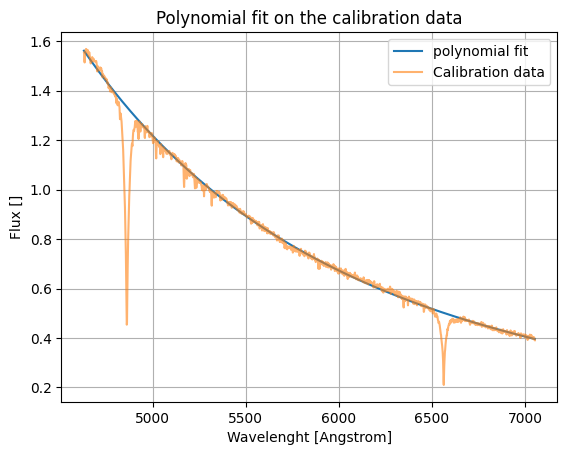

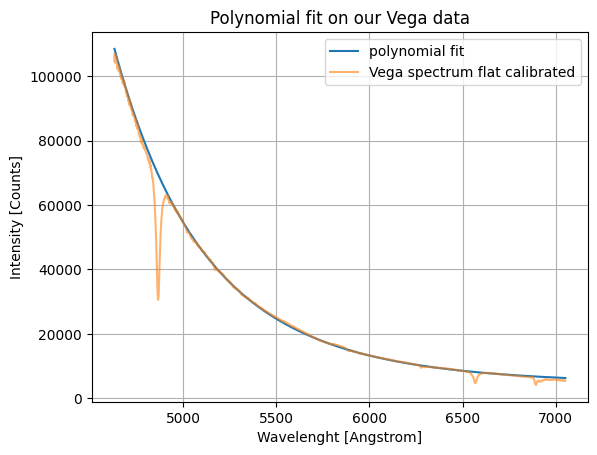

In [227]:
from scipy.optimize import curve_fit
def f(x,n,b,p):
    '''
    :purpose: Returns the value of the function f(x)=b+n/(x**p) function where b,n and p are constants
    :param x: Range of x values
    :param n: Constant
    :param b: Constant
    :param p: Constant
    :return: Value of the Gaussian function
    '''
    return b+n/(x**p)

line1 = np.polyfit((300,500),(interpolated_vega_calibration_values[300],interpolated_vega_calibration_values[500]),deg=1)
m1 = np.polyval(line1,range(300,500))

line2 = np.polyfit((1700,1900),(interpolated_vega_calibration_values[1700],interpolated_vega_calibration_values[1900]),deg=1)
m2 = np.polyval(line2,range(1700,1900))

line1_ourdata = np.polyfit((300,500),(Vega_flat_calibrated[300],Vega_flat_calibrated[500]),deg=1)
m1_ourdata = np.polyval(line1_ourdata,range(300,500))

line2_ourdata = np.polyfit((1700,1900),(Vega_flat_calibrated[1700],Vega_flat_calibrated[1900]),deg=1)
m2_ourdata = np.polyval(line2_ourdata,range(1700,1900))

no_peak_part1 = list(interpolated_vega_calibration_values[0:300])
no_peak_part2 = list(m1)
no_peak_part3 = list(interpolated_vega_calibration_values[500:1700])
no_peak_part4 = list(m2)
no_peak_part5 = list(interpolated_vega_calibration_values[1900:])

no_peak = no_peak_part1 + no_peak_part2 + no_peak_part3 + no_peak_part4 + no_peak_part5
no_peak = np.array(no_peak)

no_peak_ourdata_part1 = list(Vega_flat_calibrated[0:300])
no_peak_ourdata_part2 = list(m1_ourdata)
no_peak_ourdata_part3 = list(Vega_flat_calibrated[500:1700])
no_peak_ourdata_part4 = list(m2_ourdata)
no_peak_ourdata_part5 = list(Vega_flat_calibrated[1900:])

no_peak_ourdata = no_peak_ourdata_part1 + no_peak_ourdata_part2 + no_peak_ourdata_part3 + no_peak_ourdata_part4 + no_peak_ourdata_part5
no_peak_ourdata = np.array(no_peak_ourdata)

beta, pcov = curve_fit(f,wavelength_calibrated,no_peak, p0=(1*10**11,-1.5,1.27),bounds=((1*10**10.,-4.,0.),(1*10**12.,0.,10.)))
vega_calibration_fit = f(wavelength_calibrated, *beta)

beta_ourdata, pcov_ourdata = curve_fit(f,wavelength_calibrated,no_peak_ourdata, p0=( 1*10**39.7,10**3.7,9.5),bounds=((1*10**17.,10**2.,0.),(1*10**78.,10**5.,20.)))
Ourdata_fit = f(wavelength_calibrated, *beta_ourdata)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated,vega_calibration_fit, label = 'polynomial fit')
frame.plot(wavelength_calibrated, interpolated_vega_calibration_values, alpha = 0.6, label = 'Calibration data')
frame.set_title(f"Polynomial fit on the calibration data")
frame.grid()
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Flux []')
fig.savefig('Calibrationd data fit.png', dpi = 300)
show(fig)
close(fig)


fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated,Ourdata_fit, label = 'polynomial fit')
frame.plot(wavelength_calibrated, Vega_flat_calibrated, alpha = 0.6, label = 'Vega spectrum flat calibrated')
frame.set_title(f"Polynomial fit on our Vega data")
frame.grid()
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Intensity [Counts]')
fig.savefig('Our data fit.png', dpi = 300)
show(fig)
close(fig)

In [228]:
# Now we can calculate the response curve and calibrate our data
response = Ourdata_fit/vega_calibration_fit

# Let's apply this response curve to our data sets
Vega_response_corrected = Vega_flat_calibrated/response
Arcturus_response_corrected = Arcturus_flat_calibrated/response
Regulus_response_corrected = Regulus_flat_calibrated/response
Moon_response_corrected = Moon_flat_calibrated/response

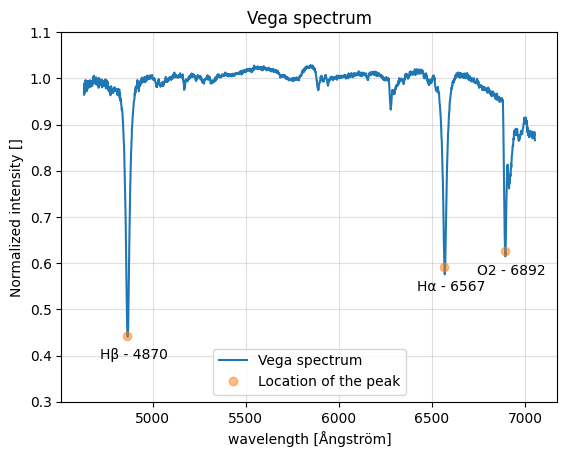

In [229]:
Flatlined_vega = Vega_response_corrected/vega_calibration_fit

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatlined_vega, label = 'Vega spectrum')
frame.plot(Vega_peaks,Flatlined_vega[Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_vega):
    frame.annotate(txt, (Vega_peaks[i], Flatlined_vega[Vega_peaks_pixel][i]), (Vega_peaks[i]-150, Flatlined_vega[Vega_peaks_pixel][i]-0.05))
frame.set_title(f"Vega spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
frame.set_ylim([0.3,1.1])
fig.savefig('Vega flatline.png', dpi=300)
show(fig)
close(fig)

[7052.08783004 7050.87100526 7049.65418048 ... 4633.0401623  4631.82333751
 4630.60651273]


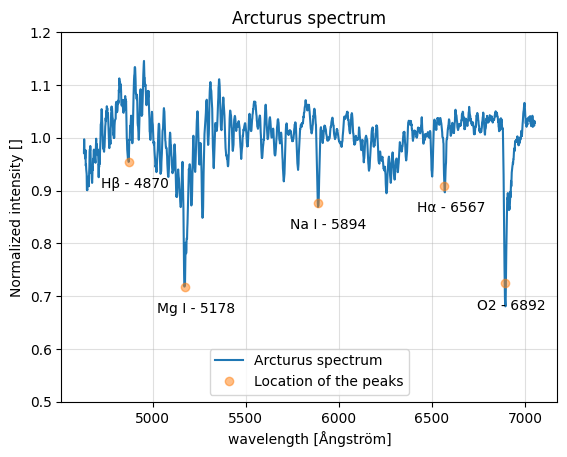

In [230]:
Arcturus_fit_function = np.polyfit(wavelength_calibrated, Arcturus_response_corrected, deg=5)
Arcturus_fit = np.polyval(Arcturus_fit_function, wavelength_calibrated)

Flatline_Arcturus = Arcturus_response_corrected/Arcturus_fit

print(wavelength_calibrated)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Arcturus, label = 'Arcturus spectrum')
frame.plot(Arcturus_peaks,Flatline_Arcturus[Arcturus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
for i, txt in enumerate(n_Arcturus):
    frame.annotate(txt, (Arcturus_peaks[i], Flatline_Arcturus[Arcturus_peaks_pixel][i]), (Arcturus_peaks[i]-150, Flatline_Arcturus[Arcturus_peaks_pixel][i]-0.05))
frame.set_title(f"Arcturus spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
frame.set_ylim([0.5,1.2])
fig.savefig('Arcturus flatline.png', dpi=300)
show(fig)
close(fig)

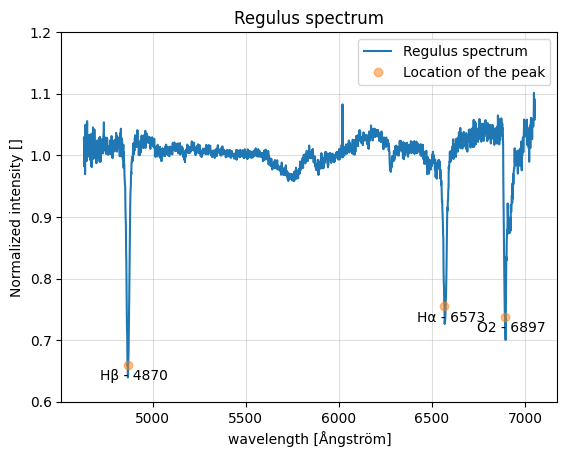

In [231]:
Regulus_fit_function = np.polyfit(wavelength_calibrated, Regulus_response_corrected, deg=5)
Regulus_fit = np.polyval(Regulus_fit_function, wavelength_calibrated)

Flatline_Regulus = Regulus_response_corrected / Regulus_fit

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Regulus, label = 'Regulus spectrum')
frame.plot(Regulus_peaks,Flatline_Regulus[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Flatline_Regulus[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Flatline_Regulus[Regulus_peaks_pixel][i]-0.025))
frame.set_title(f"Regulus spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
fig.savefig('Regulus flatline.png', dpi=300)
frame.set_ylim([0.6,1.2])
show(fig)
close(fig)

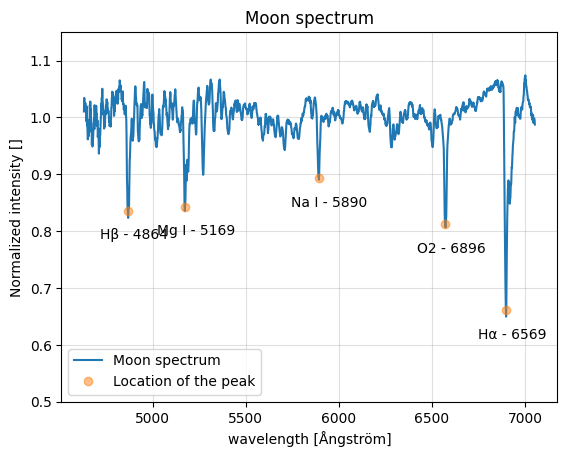

In [232]:
Moon_fit_function = np.polyfit(wavelength_calibrated, Moon_response_corrected, deg=8)
Moon_fit = np.abs(np.polyval(Moon_fit_function, wavelength_calibrated))

Flatline_Moon = (Moon_response_corrected / Moon_fit)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Moon, label = 'Moon spectrum')
frame.plot(Moon_peaks,Flatline_Moon[Moon_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Moon):
    frame.annotate(txt, (Moon_peaks[i], Flatline_Moon[Moon_peaks_pixel][i]), (Moon_peaks[i]-150, Flatline_Moon[Moon_peaks_pixel][i]-0.05))
frame.set_title(f"Moon spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.5,1.15])
fig.savefig('Moon flatline.png', dpi=300)
show(fig)
close(fig)

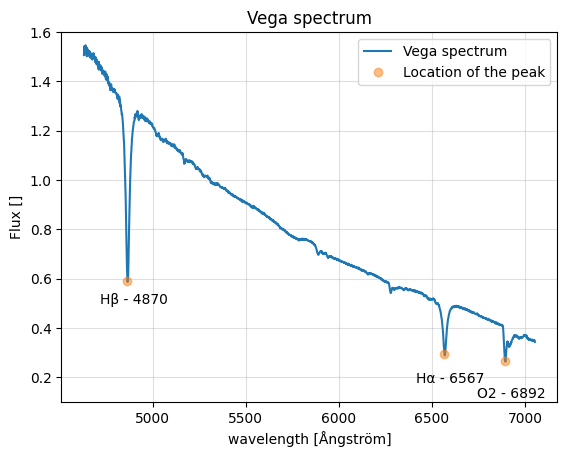

In [233]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Vega_response_corrected, label = 'Vega spectrum')
frame.plot(Vega_peaks,Vega_response_corrected[Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_vega):
    frame.annotate(txt, (Vega_peaks[i], Vega_response_corrected[Vega_peaks_pixel][i]), (Vega_peaks[i]-150-i, Vega_response_corrected[Vega_peaks_pixel][i]-0.09-i*0.03))
frame.set_title(f"Vega spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.1,1.6])
fig.savefig('Vega response calibrated.png', dpi=300)
show(fig)
close(fig)

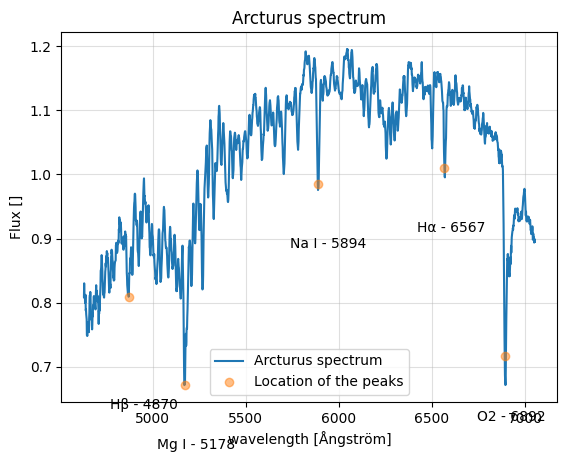

In [234]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Arcturus_response_corrected, label = 'Arcturus spectrum')
frame.plot(Arcturus_peaks,Arcturus_response_corrected[Arcturus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
for i, txt in enumerate(n_Arcturus[1::],1):
    frame.annotate(txt, (Arcturus_peaks[i], Arcturus_response_corrected[Arcturus_peaks_pixel][i]), (Arcturus_peaks[i]-150, Arcturus_response_corrected[Arcturus_peaks_pixel][i]-0.1))
frame.annotate(n_Arcturus[0], (Arcturus_peaks[0], Arcturus_response_corrected[Arcturus_peaks_pixel][0]), (Arcturus_peaks[0]-100, Arcturus_response_corrected[Arcturus_peaks_pixel][0]-0.175))
frame.set_title(f"Arcturus spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
fig.savefig('Arcturus response calibrated.png', dpi=300)
show(fig)
close(fig)

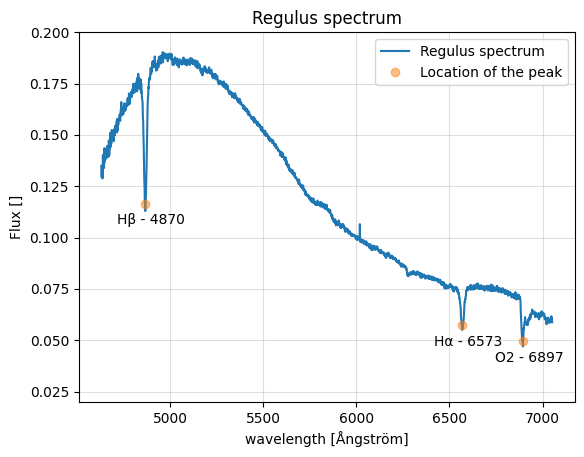

In [235]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Regulus_response_corrected, label = 'Regulus spectrum')
frame.plot(Regulus_peaks,Regulus_response_corrected[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Regulus_response_corrected[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Regulus_response_corrected[Regulus_peaks_pixel][i]-0.01))
frame.set_title(f"Regulus spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.02,0.2])
fig.savefig('Regulus response calibrated.png', dpi=300)
show(fig)
close(fig)

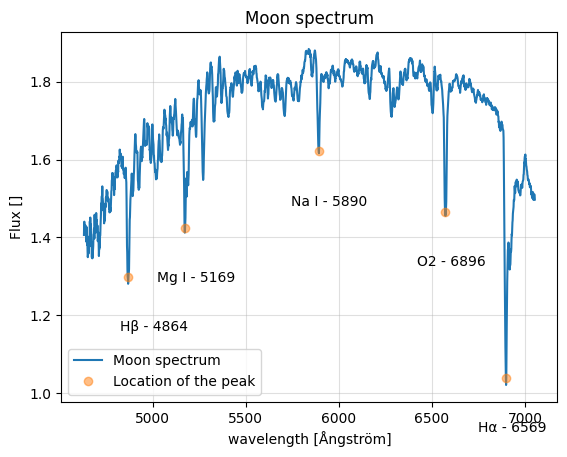

In [236]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Moon_response_corrected, label = 'Moon spectrum')
frame.plot(Moon_peaks,Moon_response_corrected[Moon_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Moon):
    if i == 0:
        frame.annotate(txt, (Moon_peaks[i], Moon_response_corrected[Moon_peaks_pixel][i]), (Moon_peaks[i]-40, Moon_response_corrected[Moon_peaks_pixel][i]-0.14))
    else:
        frame.annotate(txt, (Moon_peaks[i], Moon_response_corrected[Moon_peaks_pixel][i]), (Moon_peaks[i]-150, Moon_response_corrected[Moon_peaks_pixel][i]-0.14))
frame.set_title(f"Moon spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
fig.savefig('Moon response calibrated.png', dpi=300)
show(fig)
close(fig)

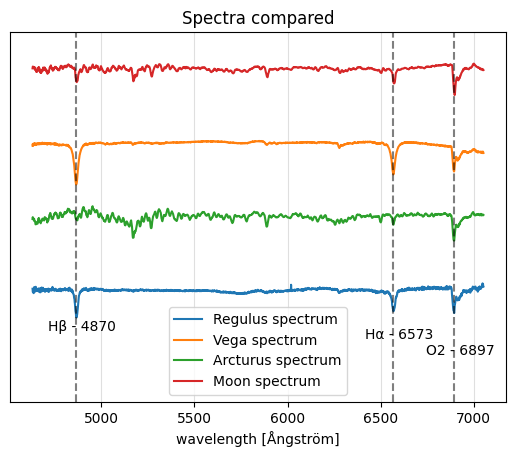

In [237]:
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(wavelength_calibrated, Flatline_Regulus, label='Regulus spectrum')
frame.plot(wavelength_calibrated, Flatlined_vega+2, label = 'Vega spectrum')
frame.plot(wavelength_calibrated, Flatline_Arcturus+1, label = 'Arcturus spectrum')
frame.plot(wavelength_calibrated, Flatline_Moon+3, label = 'Moon spectrum')
for i in Regulus_peaks:
    frame.axvline(i, color='k', linestyle='--', alpha=0.5)
# frame.plot(Regulus_peaks, Flatline_Regulus[Regulus_peaks_pixel], marker='o', alpha=0.5, linewidth=0,
#            label='Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Flatline_Regulus[Moon_peaks_pixel][i]),
                   (Regulus_peaks[i] - 150, Flatline_Regulus[Regulus_peaks_pixel][i] - i*0.2-0.2))
frame.set_title(f"Spectra compared")
frame.set_xlabel('wavelength [Ångström]')
frame.set_yticks([])
frame.legend(loc = 'lower center')
frame.grid(alpha=0.4)
frame.set_ylim([-0.5,4.5])
fig.savefig('Spectra compared.png', dpi=300)
show(fig)
close(fig)

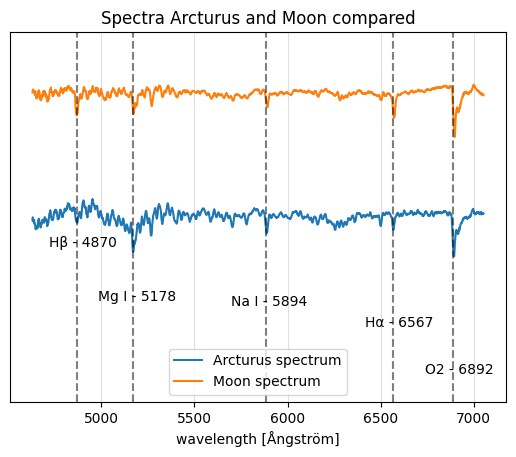

In [238]:
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(wavelength_calibrated, Flatline_Arcturus, label = 'Arcturus spectrum')
frame.plot(wavelength_calibrated, Flatline_Moon+1, label = 'Moon spectrum')
for i in Arcturus_peaks:
    frame.axvline(i, color='k', linestyle='--', alpha=0.5)
# frame.plot(Regulus_peaks, Flatline_Regulus[Regulus_peaks_pixel], marker='o', alpha=0.5, linewidth=0,
#            label='Location of the peak')
for i, txt in enumerate(n_Arcturus):
    if i == 0 or i == 3 or i == 4:
        frame.annotate(txt, (Arcturus_peaks[i], Flatline_Arcturus[Moon_peaks_pixel][i]),(Arcturus_peaks[i]-150, Flatline_Arcturus[Arcturus_peaks_pixel][i] - i*0.2-0.2))
    else:
        frame.annotate(txt, (Arcturus_peaks[i], Flatline_Arcturus[Moon_peaks_pixel][i]),(Arcturus_peaks[i]-190, Flatline_Arcturus[Arcturus_peaks_pixel][i] - i*0.2-0.2))
frame.set_title(f"Spectra Arcturus and Moon compared")
frame.set_xlabel('wavelength [Ångström]')
frame.set_yticks([])
frame.legend(loc = 'lower center')
frame.grid(alpha=0.4)
frame.set_ylim([-0.5,2.5])
fig.savefig('Spectra compared Arctrurus and Moon.png', dpi=300)
show(fig)
close(fig)

In [239]:
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelength_calibrated, Galaxy_response_corrected, label = 'Galaxy spectrum')
# # frame.plot(Vega_peaks,Galaxy_response_corrected[Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
# # for i, txt in enumerate(n_vega):
# #     frame.annotate(txt, (Vega_peaks[i], Vega_response_corrected[Vega_peaks_pixel][i]), (Vega_peaks[i]-150, Vega_response_corrected[Vega_peaks_pixel][i]-0.1))
# frame.set_title(f"Galaxy spectrum response calibrated")
# frame.set_ylabel('Intensity [Flux]')
# frame.set_xlabel('wavelength [Ångström]')
# frame.legend()
# frame.grid(alpha = 0.4)
# # fig.savefig('Vega.png', dpi=300)
# show(fig)
# close(fig)

In [240]:
# # Try a polyfit on calibration data
# y = np.poly1d(np.polyfit(wavelength_calibrated, interpolated_vega_calibration_values, 1))
# d = np.polyval(y,wavelength_calibrated)
# 
# response = vega_slice_dict_average[location_of_maximum] / d
# correction = 1/response
# response_calibrated = vega_slice_dict_average[location_of_maximum] * correction
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(wavelength_calibrated, response_calibrated)
# frame.set_title(f"{location_of_maximum} response_calibrated")
# frame.grid()
# show(fig)
# close(fig)

In [241]:
# # Let's try it on some galaxy data
# response_calibrated = horizontal_slice_dict_average[location_of_maximum]/response
# 
# 
# fig = figure()
# frame = fig.add_subplot(1, 1, 1)
# frame.plot(wavelength_calibrated, response_calibrated)
# frame.set_title(f"{location_of_maximum} response calibrated")
# frame.grid()
# show(fig)
# close(fig)

In [242]:
# np.savetxt('Flatlined_Moon.txt', Flatline_Moon)

In [243]:
# np.savetxt('relative shifts.txt', shifts)
# # np.savetxt('calibration.txt', mastercalibration)
# np.savetxt('Vega.txt', cropped[location_of_maximum])
# np.savetxt('wavelength_fortimo.txt', wavelength_calibrated)

In [244]:
# fig = figure()
# frame = fig.add_subplot(1, 1, 1)
# frame.plot(wavelength_calibrated, calibration_horizontal_dict['fibre_15'])
# frame.set_title(f"Calibration")
# frame.grid()
# show(fig)
# close(fig)

In [245]:
# hdu = fits.PrimaryHDU(data=masterlight)
# hdul = fits.HDUList([hdu])
# hdul.writeto('Arcturus.fits', overwrite=True)